In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from typing_extensions import TypedDict
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [4]:
memory = SqliteSaver.from_conn_string(":memory:")

In [5]:
import os
tav_api = os.getenv("TAVILY_API_KEY")
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

# Setup Tavily Search Tool
tool = TavilySearchResults(max_results=2, api_key=tav_api)
tools = [tool]

llm = ChatGroq(model_name="llama3-70b-8192", temperature=0)
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [6]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")

In [7]:
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

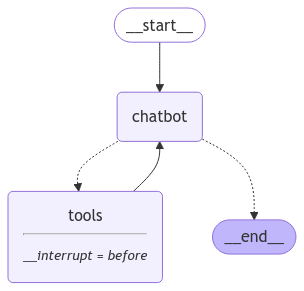

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Hello, I am John")

graph.invoke({"messages": input_message}, config=config)

AttributeError: '_GeneratorContextManager' object has no attribute 'get_next_version'

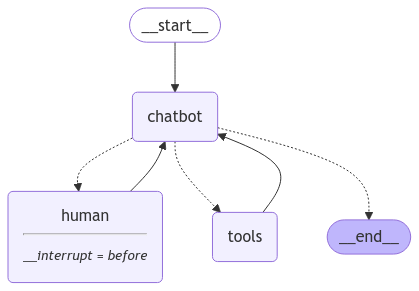

Graph Output: {'messages': [HumanMessage(content='I need a custom itinerary for my trip to Spain.', additional_kwargs={}, response_metadata={}, id='c7e4e4b8-e295-42fe-887b-01bbbe57540a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_40v2', 'function': {'arguments': '{"query":"custom itinerary for Spain trip"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1020, 'total_tokens': 1071, 'completion_time': 0.147508366, 'prompt_time': 0.076241377, 'queue_time': 0.517965442, 'total_time': 0.223749743}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_753a4aecf6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-bf4baa26-65b2-4954-b4c6-8d2f3c4a440b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'custom itinerary for Spain trip'}, 'id': 'call_40v2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1020, 'output_tokens': 51, 'tot

In [10]:
from langchain_groq import ChatGroq
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
from langchain_core.messages import AIMessage, ToolMessage, HumanMessage
from typing import Annotated
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()
tav_api = os.environ.get("TAVILY_API_KEY")

# Define custom state
class State(dict):
    messages: Annotated[list, add_messages]
    ask_human: bool  # Flag to decide when human intervention is needed

# Define a tool for escalating to human
@tool
def request_assistance():
    """Escalate to a human expert when AI cannot handle the request."""
    return "Escalating to a human expert."

# Define AI model and tools
llm = ChatGroq(model_name="llama3-70b-8192", temperature=0)
tool = TavilySearchResults(max_results=2, api_key=tav_api)
tools = [tool]
llm_with_tools = llm.bind_tools(tools + [request_assistance])

# Chatbot function
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False  # Default to AI handling the request

    if response.tool_calls and response.tool_calls[0]["name"] == "request_assistance":
        ask_human = True  # Escalate to human if required

    return {"messages": [response], "ask_human": ask_human}

# Human node
def human_node(state: State):
    return {
        "messages": [ToolMessage(content="Human agent has responded.")],
        "ask_human": False,
    }

# Build conversation graph
graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# Decision-making process
def select_next_node(state: State):
    return "human" if state["ask_human"] else tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot", select_next_node, {"human": "human", "tools": "tools", "__end__": "__end__"}
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")

# Compile graph without checkpointing
graph = graph_builder.compile(interrupt_before=["human"])

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

# Simulating a conversation
config = {"configurable": {"thread_id": "100"}}
input_message = HumanMessage(content="I need a custom itinerary for my trip to Spain.")
response = graph.invoke({"messages": [input_message]}, config=config)

# Print output to verify
print("Graph Output:", response)


In [18]:
config = {"configurable": {"thread_id": "104"}}
input_message = HumanMessage(content="What are the latest updates on AI regulation in Europe?")
response = graph.invoke({"messages": [input_message]}, config=config)

# Debugging: Print the raw response
print("\n=== RAW RESPONSE DEBUG ===")
print(type(response))  # Check type of response
print(response)  # Print raw response
print("==========================\n")

# Function to print response clearly
def pretty_print_response(response):
    print("\n" + "=" * 60)
    print("🔵 **STATUS UPDATE**")

    if isinstance(response, list) and response:  # If response is a list (likely from an external tool)
        print("✅ **Using External Tool: Tavily Search Tool**")
        for i, res in enumerate(response, start=1):
            print(f"\n📌 **Result {i}:**")
            print(f"🔗 **URL:** {res.get('url', 'N/A')}")
            print(f"📜 **Content:** {res.get('content', 'No summary available')[:300]}...")  # Truncated for clarity

    elif isinstance(response, dict) and "text" in response:  # If response is a dict with 'text' key
        print("💡 **Answering Directly from Model**")
        print(f"\n📝 **Response:** {response['text']}")

    elif isinstance(response, str) and response.strip():  # If response is a non-empty string (direct model response)
        print("💡 **Answering Directly from Model**")
        print(f"\n📝 **Response:** {response}")

    else:  # If response is empty or unclear
        print("⚠️ **No clear response detected. Possible escalation to a human needed.**")

    print("=" * 60 + "\n")

# Call the function to display response clearly
pretty_print_response(response)



=== RAW RESPONSE DEBUG ===
<class 'langgraph.pregel.io.AddableValuesDict'>
{'messages': [HumanMessage(content='What are the latest updates on AI regulation in Europe?', additional_kwargs={}, response_metadata={}, id='9ba3bfe1-2506-4b30-b018-3f853fc2e9be'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8v8z', 'function': {'arguments': '{"query":"latest updates on AI regulation in Europe"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 1020, 'total_tokens': 1073, 'completion_time': 0.157119746, 'prompt_time': 0.059761752, 'queue_time': 0.017205561999999994, 'total_time': 0.216881498}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_753a4aecf6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-80e07339-21a7-4e1f-a7dd-9eb1d63bef6d-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest updates on AI regulation in Europe'}, 'id': 

In [16]:
config = {"configurable": {"thread_id": "102"}}
input_message = HumanMessage(content="Explain quantum computing in simple terms.")
response = graph.invoke({"messages": [input_message]}, config=config)
pretty_print_response(response)



🔵 **STATUS UPDATE**
⚠️ No response generated. Possible escalation to a human needed.



In [13]:
config = {"configurable": {"thread_id": "103"}}
input_message = HumanMessage(content="Write a short poem about the ocean.")
response = graph.invoke({"messages": [input_message]}, config=config)
pretty_print_response(response)



============================== Graph Output ==============================


--- Message 1 ---
Message: Write a short poem about the ocean.

--- Message 2 ---
Message: 

--- Message 3 ---
Message: [{"url": "https://www.familyfriendpoems.com/poems/nature/ocean/", "content": "18 Poems about the Beauty of the Ocean and Seas · 1. Sea Fever · 2. To Little Wave · 3. Promises Of A New Day · 4. A Miracle To Behold · 5. The Ocean · 6. Storm"}, {"url": "https://www.poetryfoundation.org/poems/57286/the-ocean", "content": "The ocean has its silent caves, Deep, quiet, and alone; Though there be fury on the waves, Beneath them there is none."}]

--- Message 4 ---
Message: 

============================== End of Output ==============================



In [14]:
config = {"configurable": {"thread_id": "104"}}
input_message = HumanMessage(content="What are the latest updates on AI regulation in Europe?")
response = graph.invoke({"messages": [input_message]}, config=config)
pretty_print_response(response)



============================== Graph Output ==============================


--- Message 1 ---
Message: What are the latest updates on AI regulation in Europe?

--- Message 2 ---
Message: 

--- Message 3 ---
Message: [{"url": "https://digital-strategy.ec.europa.eu/en/policies/regulatory-framework-ai", "content": "The AI Act (Regulation (EU) 2024/1689 laying down harmonised rules on artificial intelligence)is the first-ever comprehensive legal framework on AI worldwide. The AI Act sets out a clear set of risk-based rules for AI developers and deployers regarding specific uses of AI. The AI Act defines 4 levels of risk for AI systems: The AI Act does not introduce rules for AI that is deemed minimal or no risk. How does it all work in practice for providers of high-risk AI systems? How does it all work in practice for providers of high-risk AI systems? The European AI Office, established in February 2024 within the Commission, oversees the AI Act’s enforcement and implementation in the 

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    user_preferences: dict  # Store user preferences like budget, favorite locations

def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages": [response], "user_preferences": state.get("user_preferences", {})}

# Example input with user preferences
config = {"configurable": {"thread_id": "200"}}
input_message = HumanMessage(content="I want a budget-friendly trip to Spain.")
graph.invoke({"messages": input_message, "user_preferences": {"budget": "low"}}, config=config)


{'messages': [HumanMessage(content='I want a budget-friendly trip to Spain.', additional_kwargs={}, response_metadata={}, id='e173e79c-f6b9-4d69-891e-15c813abc8c2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4erp', 'function': {'arguments': '{"query":"budget-friendly trip to Spain"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 1018, 'total_tokens': 1069, 'completion_time': 0.146043169, 'prompt_time': 0.06454893, 'queue_time': 0.23431689900000002, 'total_time': 0.210592099}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_753a4aecf6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-aa04ea4b-5500-488b-b6cd-61080804e4a8-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'budget-friendly trip to Spain'}, 'id': 'call_4erp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1018, 'output_tokens': 51, 'total_tokens': 1069}